In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from tqdm.auto import tqdm
import numpy as np

import sys
sys.path.append("../")
import json

import logging
from src.utils import logging_utils
from src.utils import env_utils
from src import functional

logger = logging.getLogger(__name__)

logging.basicConfig(
    level=logging.INFO,
    format=logging_utils.DEFAULT_FORMAT,
    datefmt=logging_utils.DEFAULT_DATEFMT,
    stream=sys.stdout,
)

import torch
import transformers

logger.info(f"{torch.__version__=}, {torch.version.cuda=}")
logger.info(f"{torch.cuda.is_available()=}, {torch.cuda.device_count()=}, {torch.cuda.get_device_name()=}")
logger.info(f"{transformers.__version__=}")

/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2024-09-09 20:57:14 __main__ INFO     torch.__version__='2.4.1+cu121', torch.version.cuda='12.1'
2024-09-09 20:57:14 __main__ INFO     torch.cuda.is_available()=True, torch.cuda.device_count()=1, torch.cuda.get_device_name()='NVIDIA RTX A6000'
2024-09-09 20:57:14 __main__ INFO     transformers.__version__='4.44.2'


In [3]:
from dataclasses_json import DataClassJsonMixin
from dataclasses import dataclass, field, fields
from typing import Optional
import random
from src.dataset import BridgeSample, BridgeRelation, BridgeDataset
from src.dataset import load_bridge_relation, load_bridge_relations, load_bridge_dataset        

In [4]:
import torch

from nnsight import LanguageModel
from src.models import ModelandTokenizer

model_key = "meta-llama/Meta-Llama-3-8B-Instruct"

mt = ModelandTokenizer(
    model_key=model_key,
    torch_dtype=torch.float16,
)

2024-09-09 20:57:14 accelerate.utils.modeling INFO     We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).


Loading checkpoint shards: 100%|██████████| 4/4 [00:04<00:00,  1.20s/it]

2024-09-09 20:57:19 src.models INFO     loaded model </home/local_arnab/Codes/00_MODEL/meta-llama/Meta-Llama-3-8B-Instruct> | size: 15316.516 MB | dtype: torch.float16 | device: cuda:0


In [5]:
states_cache_dir = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "cache_states/mean",
    mt.name.split("/")[-1],
    "wikipedia"
)

# os.listdir(states_cache_dir)


In [6]:
# import numpy as np

# def load_mean_states():
#     mean_states = {}
#     total_tokens = 0
#     for doc_cache in os.listdir(states_cache_dir):
#         npz_file = np.load(os.path.join(states_cache_dir, doc_cache), allow_pickle=True)
#         input_ids = npz_file["input_ids"]
#         token_count = input_ids.shape[1]
#         outputs = npz_file["outputs"].item()
#         for key, value in outputs.items():
#             if key not in mean_states:
#                 mean_states[key] = value * token_count
#             else:
#                 mean_states[key] += value * token_count
#         total_tokens += token_count
    
#     for key in mean_states.keys():
#         mean_states[key] = torch.Tensor(mean_states[key]).squeeze() / total_tokens
    
#     return mean_states

# # npz_file = np.load(os.path.join(states_cache_dir, "0.npz"), allow_pickle=True)
# # npz_file.files

# # outputs = npz_file["outputs"].item()

# mean_states = load_mean_states()

In [7]:
attn_cache_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "cache_heads",
    "ablated_head_outputs.npz",
)

# os.listdir(attn_cache_path)

npz_file = np.load(attn_cache_path, allow_pickle=True)
# npz_file["model.layers.0.self_attn"].item()

ablated_attn_states = {}

for i in range(mt.n_layer):
    attn_module_name = mt.attn_module_name_format.format(i)
    ablated_attn_states[attn_module_name] = torch.Tensor(npz_file[attn_module_name].item()["sum"])

In [8]:
from typing import Literal
from src.utils import experiment_utils

experiment_utils.set_seed(123456)

relation_name: Literal[
    "architect_building",
    "movie_actor",
    "sport_players",
    "superpower_characters",
    "all",
] = "sport_players"


cached_known_dir = os.path.join(
    env_utils.DEFAULT_DATA_DIR, "bridge_cached", 
    mt.name.split("/")[-1]
)
# known_data_file = os.listdir(cached_known_dir)[-1]
known_data_file = "filtered_2024-09-06T00:58:32.777195.json"

cached_known_dir = os.path.join(
    env_utils.DEFAULT_DATA_DIR, "bridge_cached", mt.name.split("/")[-1]
)
with open(os.path.join(cached_known_dir, known_data_file), "r") as f:
    json_data = json.load(f)

dataset = BridgeDataset.from_dict(json_data)
if relation_name != "all":
    relation_icq = None
    for rel in json_data["relations"]:
        if rel["name"] == relation_name:
            relation_icq = BridgeRelation.from_dict(rel)
            break
    assert (
        relation_icq is not None
    ), f"{relation_name=} is not found. Available relations: {[r['name'] for r in json_data['relations']]}"
    dataset.examples = relation_icq.examples
dataset.ensure_icl_not_in_examples()

2024-09-09 20:57:19 src.utils.experiment_utils INFO     setting all seeds to 123456
2024-09-09 20:57:19 src.dataset INFO     initialized bridge relation superpower_characters with 43 examples
2024-09-09 20:57:19 src.dataset INFO     initialized bridge relation sport_players with 58 examples
2024-09-09 20:57:19 src.dataset INFO     initialized bridge relation movie_actor with 58 examples


2024-09-09 20:57:19 src.dataset INFO     initialized bridge relation architect_building with 30 examples
2024-09-09 20:57:19 src.dataset INFO     initialized bridge relation none with 46 examples
2024-09-09 20:57:19 src.dataset INFO     initialized bridge dataset with 5 relations and 293 examples
2024-09-09 20:57:19 src.dataset INFO     initialized bridge relation sport_players with 58 examples


In [9]:
for idx, sample in enumerate(dataset.examples):
    print(idx, "=>", sample)

0 => baseball - a sport where both Babe Ruth and Hank Aaron are known for.
1 => boxing - a sport where both Floyd Mayweather and Manny Pacquiao are known for.
2 => athletics - a sport where both Usain Bolt and Carl Lewis are known for.
3 => basketball - a sport where both Michael Jordan and LeBron James are known for.
4 => soccer - a sport where both Zinedine Zidane and Ronaldinho are known for.
5 => table tennis - a sport where both Zhang Jike and Timo Boll are known for.
6 => rugby - a sport where both Richie McCaw and Brian O'Driscoll are known for.
7 => rugby - a sport where both Jonah Lomu and Dan Carter are known for.
8 => cricket - a sport where both Sachin Tendulkar and Brian Lara are known for.
9 => surfing - a sport where both Kelly Slater and Andy Irons are known for.
10 => cricket - a sport where both Shane Warne and Muttiah Muralitharan are known for.
11 => wrestling - a sport where both Hulk Hogan and The Rock are known for.
12 => soccer - a sport where both Pelé and Dieg

In [10]:
idx = 19

question, answer = dataset[idx]
print(question)
print(answer)

Given two entities, find a common link between them.
#
What is a common link between Michelle Williams and Marilyn Monroe?
A: My Week with Marilyn - a movie where Michelle Williams played the role of Marilyn Monroe.
#
What is a common link between Fallingwater and Guggenheim Museum?
A: Frank Lloyd Wright - who was the architect of both buildings Fallingwater and Guggenheim Museum.
#
What is a common link between Roger Federer and Rafael Nadal?
A: tennis - a sport where both Roger Federer and Rafael Nadal are known for.
#
What is a common link between Charles Darwin and Flamenco?
A: none - there is no connection between Charles Darwin and Flamenco.
#
What is a common link between Mr. Fantastic and Elastigirl?
A: elastic powers - an attribute that both characters Mr. Fantastic and Elastigirl possess.
#
What is a common link between Jonah Lomu and Richie McCaw?
A:
rugby - a sport where both Jonah Lomu and Richie McCaw are known for.


In [11]:
from src.tokens import prepare_input

inputs = prepare_input(prompts=question, tokenizer=mt)

In [12]:
from src.functional import predict_next_token

clean_predictions = predict_next_token(
    mt=mt,
    inputs=inputs
)[0]
clean_predictions

You're using a PreTrainedTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
We detected that you are passing `past_key_values` as a tuple and this is deprecated and will be removed in v4.43. Please use an appropriate `Cache` class (https://huggingface.co/docs/transformers/v4.41.3/en/internal/generation_utils#transformers.Cache)


[PredictedToken(token=' rugby', prob=0.38151416182518005, logit=20.859375, token_id=47550),
 PredictedToken(token=' New', prob=0.2663397789001465, logit=20.5, token_id=1561),
 PredictedToken(token=' All', prob=0.16929587721824646, logit=20.046875, token_id=2052),
 PredictedToken(token=' Rugby', prob=0.14708681404590607, logit=19.90625, token_id=52002),
 PredictedToken(token=' they', prob=0.013054695911705494, logit=17.484375, token_id=814)]

In [13]:
from src.functional import get_hs, logit_lens, PatchSpec

ablate_attns : list[PatchSpec] = [
    PatchSpec(
        location=(mt.attn_module_name_format.format(i), -1),
        patch=ablated_attn_states[mt.attn_module_name_format.format(i)]
    ) 
    for i in range(15, 31)
]

last_h = get_hs(
    mt=mt,
    input=inputs,
    locations=(mt.layer_name_format.format(mt.n_layer-1), -1),
    patches=ablate_attns
)

ablated_pred, track_ans = logit_lens(
    mt=mt,
    h=last_h,
    interested_tokens=[clean_predictions[0].token_id]
)
ablated_pred, track_ans

([PredictedToken(token=' New', prob=0.1621457189321518, logit=12.0, token_id=1561),
  PredictedToken(token=' they', prob=0.046819884330034256, logit=10.7578125, token_id=814),
  PredictedToken(token=' Rugby', prob=0.044328171759843826, logit=10.703125, token_id=52002),
  PredictedToken(token=' Football', prob=0.037915896624326706, logit=10.546875, token_id=21424),
  PredictedToken(token=' being', prob=0.025455527007579803, logit=10.1484375, token_id=1694)],
 {47550: (7,
   PredictedToken(token=' rugby', prob=0.019365545362234116, logit=9.875, token_id=47550))})

In [14]:
list(track_ans.values())[0]

(7,
 PredictedToken(token=' rugby', prob=0.019365545362234116, logit=9.875, token_id=47550))

In [15]:
clean_predictions[0].token_id

47550

In [16]:
from tqdm.auto import tqdm

@torch.inference_mode()
def check_ablation_effect(
    mt: ModelandTokenizer,
    question: str,
    direction: Literal["asc", "desc"] = "asc"
):
    inputs = prepare_input(prompts=question, tokenizer=mt)
    answer = predict_next_token(mt=mt, inputs=inputs, k=1)[0][0]
    ablation_spec: list[PatchSpec] = []
    effects = {}

    layers = list(range(mt.n_layer)) if direction == "asc" else list(range(mt.n_layer-1, -1, -1))
    for i in tqdm(layers):
        ablation_spec.append(
            PatchSpec(
                location=(mt.attn_module_name_format.format(i), -1),
                patch=ablated_attn_states[mt.attn_module_name_format.format(i)]
                # patch=torch.zeros_like(mean_states[mt.mlp_module_name_format.format(i)])
            )
        )

        ablated_last_h = get_hs(
            mt=mt, 
            input=inputs,
            locations=(mt.layer_name_format.format(mt.n_layer-1), -1),
            patches=ablation_spec
        )

        ablated_pred, track_ans =logit_lens(mt=mt, h=ablated_last_h, interested_tokens=[answer.token_id])
        rank, track_ans = list(track_ans.values())[0]
        effects[i] = track_ans
    
    return answer, effects

In [17]:
from src.utils.typing import PredictedToken

def process_ablation_effects(
    ablation_effects: list[tuple[PredictedToken], dict[int, PredictedToken]],
    metric: str = "prob"
):
    scores = {}
    for answer, effects in ablation_effects:
        for layer, effect in effects.items():
            if layer not in scores:
                scores[layer] = []
            scores[layer].append(getattr(effect, metric)/getattr(answer, metric))
    scores = {k: np.mean(v) for k, v in scores.items()}
    return scores

In [18]:
answer, effects_asc = check_ablation_effect(mt=mt, question=question)

100%|██████████| 32/32 [00:19<00:00,  1.67it/s]


In [19]:
ablation_effects_asc = []
ablation_effects_desc = []

# limit = 5
limit = len(dataset)
for idx in range(limit):
    print(f"Processing {idx+1}/{limit}")
    question, answer = dataset[idx]
    answer, effects = check_ablation_effect(mt=mt, question=question)
    ablation_effects_asc.append((answer, effects))

    answer, effects = check_ablation_effect(mt=mt, question=question, direction="desc")
    ablation_effects_desc.append((answer, effects))

Processing 1/58


100%|██████████| 32/32 [00:19<00:00,  1.66it/s]


Processing 2/58


100%|██████████| 32/32 [00:19<00:00,  1.65it/s]


Processing 3/58


100%|██████████| 32/32 [00:19<00:00,  1.65it/s]


Processing 4/58


100%|██████████| 32/32 [00:19<00:00,  1.65it/s]


Processing 5/58


100%|██████████| 32/32 [00:19<00:00,  1.65it/s]


Processing 6/58


100%|██████████| 32/32 [00:19<00:00,  1.66it/s]


Processing 7/58


100%|██████████| 32/32 [00:19<00:00,  1.65it/s]


Processing 8/58


100%|██████████| 32/32 [00:19<00:00,  1.63it/s]


Processing 9/58


100%|██████████| 32/32 [00:19<00:00,  1.63it/s]


Processing 10/58


100%|██████████| 32/32 [00:19<00:00,  1.64it/s]


Processing 11/58


100%|██████████| 32/32 [00:19<00:00,  1.63it/s]


Processing 12/58


100%|██████████| 32/32 [00:19<00:00,  1.65it/s]


Processing 13/58


100%|██████████| 32/32 [00:19<00:00,  1.66it/s]


Processing 14/58


100%|██████████| 32/32 [00:19<00:00,  1.66it/s]


Processing 15/58


100%|██████████| 32/32 [00:19<00:00,  1.64it/s]


Processing 16/58


100%|██████████| 32/32 [00:19<00:00,  1.65it/s]


Processing 17/58


100%|██████████| 32/32 [00:19<00:00,  1.65it/s]


Processing 18/58


100%|██████████| 32/32 [00:19<00:00,  1.67it/s]


Processing 19/58


100%|██████████| 32/32 [00:19<00:00,  1.64it/s]


Processing 20/58


100%|██████████| 32/32 [00:19<00:00,  1.63it/s]


Processing 21/58


100%|██████████| 32/32 [00:19<00:00,  1.62it/s]


Processing 22/58


100%|██████████| 32/32 [00:19<00:00,  1.65it/s]


Processing 23/58


100%|██████████| 32/32 [00:19<00:00,  1.68it/s]


Processing 24/58


100%|██████████| 32/32 [00:19<00:00,  1.62it/s]


Processing 25/58


100%|██████████| 32/32 [00:19<00:00,  1.65it/s]


Processing 26/58


100%|██████████| 32/32 [00:19<00:00,  1.63it/s]


Processing 27/58


100%|██████████| 32/32 [00:19<00:00,  1.64it/s]


Processing 28/58


100%|██████████| 32/32 [00:19<00:00,  1.62it/s]


Processing 29/58


100%|██████████| 32/32 [00:19<00:00,  1.65it/s]


Processing 30/58


100%|██████████| 32/32 [00:19<00:00,  1.64it/s]


Processing 31/58


100%|██████████| 32/32 [00:19<00:00,  1.63it/s]


Processing 32/58


100%|██████████| 32/32 [00:19<00:00,  1.63it/s]


Processing 33/58


100%|██████████| 32/32 [00:19<00:00,  1.62it/s]


Processing 34/58


100%|██████████| 32/32 [00:19<00:00,  1.64it/s]


Processing 35/58


100%|██████████| 32/32 [00:19<00:00,  1.65it/s]


Processing 36/58


100%|██████████| 32/32 [00:19<00:00,  1.66it/s]


Processing 37/58


100%|██████████| 32/32 [00:19<00:00,  1.67it/s]


Processing 38/58


100%|██████████| 32/32 [00:19<00:00,  1.68it/s]


Processing 39/58


100%|██████████| 32/32 [00:19<00:00,  1.62it/s]


Processing 40/58


100%|██████████| 32/32 [00:19<00:00,  1.61it/s]


Processing 41/58


100%|██████████| 32/32 [00:18<00:00,  1.75it/s]


Processing 42/58


100%|██████████| 32/32 [00:18<00:00,  1.69it/s]


Processing 43/58


100%|██████████| 32/32 [00:19<00:00,  1.67it/s]


Processing 44/58


100%|██████████| 32/32 [00:18<00:00,  1.73it/s]


Processing 45/58


100%|██████████| 32/32 [00:18<00:00,  1.76it/s]


Processing 46/58


100%|██████████| 32/32 [00:18<00:00,  1.73it/s]


Processing 47/58


100%|██████████| 32/32 [00:18<00:00,  1.73it/s]


Processing 48/58


100%|██████████| 32/32 [00:18<00:00,  1.73it/s]


Processing 49/58


100%|██████████| 32/32 [00:18<00:00,  1.72it/s]


Processing 50/58


100%|██████████| 32/32 [00:18<00:00,  1.76it/s]


Processing 51/58


100%|██████████| 32/32 [00:18<00:00,  1.76it/s]


Processing 52/58


100%|██████████| 32/32 [00:18<00:00,  1.75it/s]


Processing 53/58


100%|██████████| 32/32 [00:18<00:00,  1.76it/s]


Processing 54/58


100%|██████████| 32/32 [00:18<00:00,  1.76it/s]


Processing 55/58


100%|██████████| 32/32 [00:18<00:00,  1.75it/s]


Processing 56/58


100%|██████████| 32/32 [00:18<00:00,  1.76it/s]


Processing 57/58


100%|██████████| 32/32 [00:18<00:00,  1.76it/s]


Processing 58/58


100%|██████████| 32/32 [00:18<00:00,  1.76it/s]


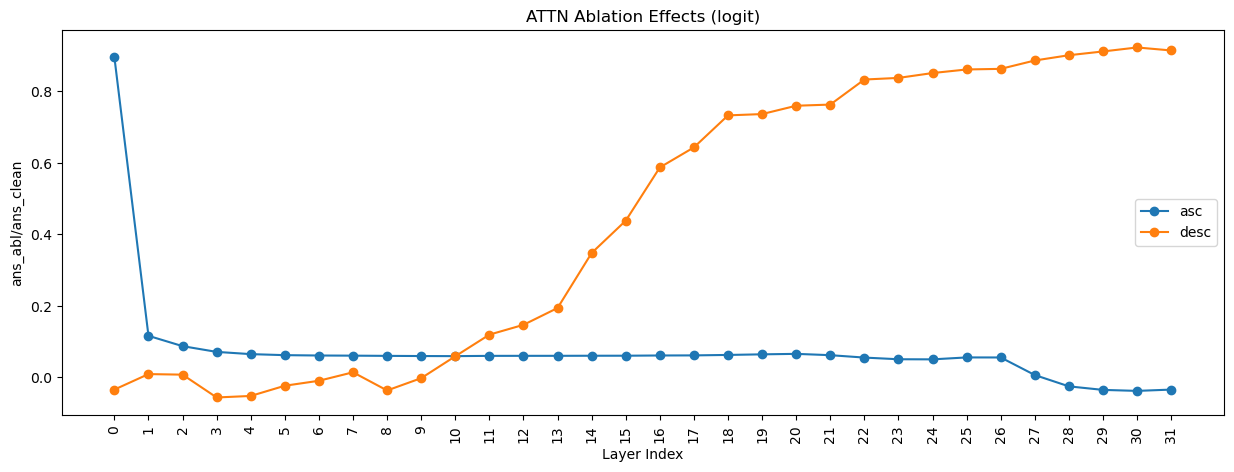

In [34]:
metric = "logit"

scores_asc = process_ablation_effects(ablation_effects_asc, metric)
scores_desc = process_ablation_effects(ablation_effects_desc, metric)

import matplotlib.pyplot as plt

keys = list(range(mt.n_layer))

plt.figure(figsize=(15, 5))
plt.title(f"ATTN Ablation Effects ({metric})")
plt.plot([scores_asc[k] for k in keys], marker="o", label="asc")
plt.plot([scores_desc[k] for k in keys], marker="o", label="desc")
plt.xticks(keys, rotation=90)
plt.xlabel("Layer Index")
plt.ylabel("ans_abl/ans_clean")
plt.legend()

plt.show()